<a href="https://www.kaggle.com/code/felipesquire/eda-no-show?scriptVersionId=90969990" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noshowappointments/KaggleV2-May-2016.csv


# Introduction

Main Question: Why do 30% of patients miss their scheduled appointments?

01. PatientId = Identification of a patient
02. AppointmentID = Identification of each appointment
03. Gender = Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man.
04. DataMarcacaoConsulta = The day of the actuall appointment, when they have to visit the doctor.
05. DataAgendamento = The day someone called or registered the appointment, this is before appointment of course.
06. Age = How old is the patient.
07. Neighbourhood = Where the appointment takes place.
08. Scholarship = True of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
09. Hipertension = True or False
10. Diabetes = True or False
11. Alcoholism = True or False
12. Handcap = True or False
13. SMS_received = 1 or more messages sent to the patient.
14. No-show = True or False

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

In [3]:
df = pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


# Data Wrangling

**First off -> We must deal with the date columns format which are: ScheduledDay and AppointmentDay.**

In [4]:
#Solving Schedule day problem by splitting it into 2 columns
df['Schedule Time'] = pd.to_datetime(df['ScheduledDay'], format='%Y-%m-%d').dt.strftime('%r')
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
#Splittign apointmnent time now
df['Appointment Time'] = pd.to_datetime(df['AppointmentDay'], format='%Y-%m-%d').dt.strftime('%r')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PatientId         110527 non-null  float64
 1   AppointmentID     110527 non-null  int64  
 2   Gender            110527 non-null  object 
 3   ScheduledDay      110527 non-null  object 
 4   AppointmentDay    110527 non-null  object 
 5   Age               110527 non-null  int64  
 6   Neighbourhood     110527 non-null  object 
 7   Scholarship       110527 non-null  int64  
 8   Hipertension      110527 non-null  int64  
 9   Diabetes          110527 non-null  int64  
 10  Alcoholism        110527 non-null  int64  
 11  Handcap           110527 non-null  int64  
 12  SMS_received      110527 non-null  int64  
 13  No-show           110527 non-null  object 
 14  Schedule Time     110527 non-null  object 
 15  Appointment Time  110527 non-null  object 
dtypes: float64(1), int64

In [5]:
#Lets put a standard formatting on the column names
df.rename(columns= lambda x: x.lower().replace(' ','_'), inplace=True)
#Now I'll change the no-show columns formatting and values in order to make it less confusing
df.rename(columns={'no-show':'showedup'},inplace=True)
#Lets change the column values to a binary type 0-1
df['showedup'].replace('Yes',' ',inplace=True)
df['showedup'].replace('No','1',inplace=True)
df['showedup'].replace(' ','0',inplace=True)
df['showedup'] = df.showedup.astype('int64')

df.columns

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'showedup',
       'schedule_time', 'appointment_time'],
      dtype='object')

In [6]:
#It looks like our appointment_time is always the same so let's remove this column since it wont be any useful
df.appointment_time.unique()
df.drop(columns='appointment_time',inplace=True)

In [7]:
df.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,showedup
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.798067
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


It looks like our data has a problem at the column age since the minimum value is -1 and such age is impossible. Now I'll investigate how many rows has this value and determine if we will treat this data or remove it.

In [8]:
len(df[df['age'] == -1]) #It looks like it's only one row so I'll proceed and remove it

df = df[df['age'] >= 0] #Now we must investigate the rows where the age is 0

#len(df[df['age'] == 0]) #There's 3539 rows with such value!

df[df['age'] == 0].describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,showedup
count,3.539000e+03,3.539000e+03,3539.0,3539.000000,3539.0,3539.0,3539.0,3539.000000,3539.000000,3539.000000
mean,1.539027e+14,5.671375e+06,0.0,0.014693,0.0,0.0,0.0,0.000283,0.253461,0.819441
std,2.640133e+14,7.005467e+04,0.0,0.120340,0.0,0.0,0.0,0.016810,0.435054,0.384707
min,2.699191e+08,5.317393e+06,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,4.154026e+12,5.634852e+06,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,3.288134e+13,5.675158e+06,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,9.626769e+13,5.722168e+06,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000
max,9.978457e+14,5.790135e+06,0.0,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


I'm a brazilian and I can make an statement that this "Scholarship" it's actually a social welfare programm that provides social and economic benefits for the poor, and therefore it is possible to have people with age 0 on this dataset since it means that they are babies born within a family that is member of this programm. Therefore we will proceed with these rows on the data.

# EDA

# EDA

Let's break this investigation into parts.
Firstly let's broadly explore our dataset.

01. What's the distribution of age and gender? 
02. How many people has been contemplated by the scholarship?
03. How many people has any kind of health problem or disability? 
04. How many people showed up at their appointments? Did someone make more than one appointment? 

                 patientid
showedup gender           
0        F        0.132041
         M        0.069893
1        F        0.517932
         M        0.280133
The share of people that showedup is [0.79806561]
The gender share of female is [0.64997376]
The share of people with scholarship is [0.90173353]


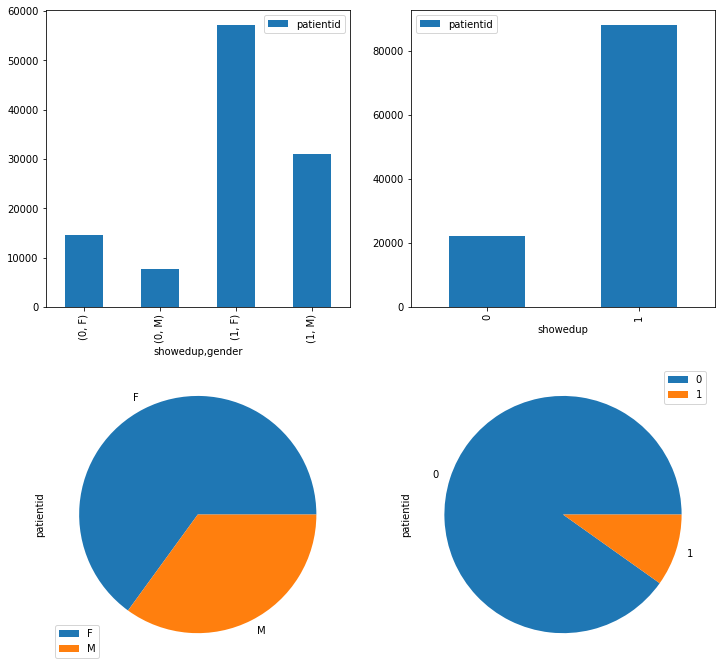

In [9]:
graf1 = pd.DataFrame(df.groupby(['showedup','gender']).patientid.count())
graf2 = pd.DataFrame(df.groupby(['showedup']).patientid.count())
graf3 = pd.DataFrame(df.groupby('gender').patientid.count())
graf4 = pd.DataFrame(df.groupby('scholarship').patientid.count())
#graf1.plot(kind='scatter', x='showedup', y='patientid')
fig, axes = plt.subplots(nrows=2, ncols=2)

graf1.plot(kind='bar', figsize=[12,12], ax=axes[0,0])
print(graf1/graf1.sum())
graf2.plot(kind='bar', figsize=[12,12], ax=axes[0,1])
print('The share of people that showedup is {}'.format((graf2['patientid'][1]/graf2.sum()).values))
graf3.plot(kind='pie', figsize=[12,12], ax=axes[1,0], subplots=True)
print('The gender share of female is {}'.format((graf3['patientid'][0]/graf3.sum()).values))
graf4.plot(kind='pie', figsize=[12,12], ax=axes[1,1], subplots=True)
print('The share of people with scholarship is {}'.format((graf4['patientid'][0]/graf4.sum()).values))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

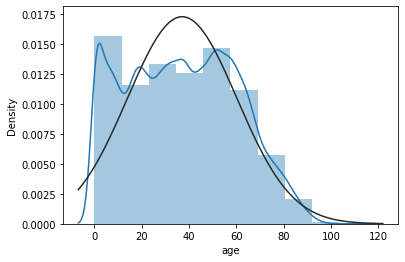

In [10]:
#df.age.plot(kind='hist')
from scipy.stats import norm

sns.distplot(df.age, fit=norm, bins=10)

It seems like most of our data is represented by Female (~60%).

The share of people that showed up on their appointments is ~80% which is composed by 51% of Females and 28% of Males.

Only ~10% of the people is has a scholarship.

Our age distribution tends to follow a normal distribution, although it may need some transformations to turn it into a proper normal distribution. It looks like most of the patients are within 20-60 years old, and there's a peak in the 0 years old for a reason.

Now that we checked the distribution among the profile of our attendee and non-attended, we must check the diseases/malfunctions distribution

The share of people without hipertension is [0.80275229]
The share of people without diabetes is [0.92813456]
The share of people without alcoholism is [0.96959991]
The share of people that arent handcap is [0.97972423]


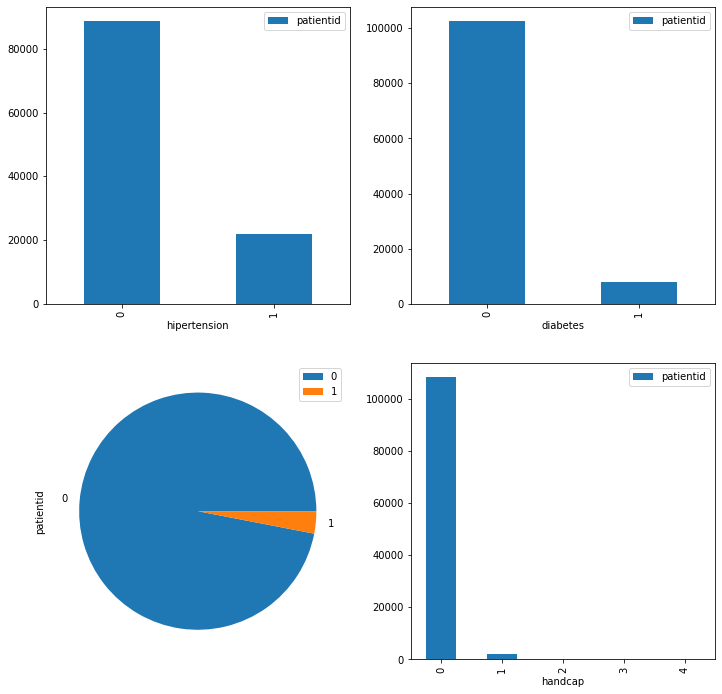

In [11]:
graf1 = pd.DataFrame(df.groupby(['hipertension']).patientid.count())
graf2 = pd.DataFrame(df.groupby(['diabetes']).patientid.count())
graf3 = pd.DataFrame(df.groupby('alcoholism').patientid.count())
graf4 = pd.DataFrame(df.groupby('handcap').patientid.count())

#graf1.plot(kind='scatter', x='showedup', y='patientid')

fig, axes = plt.subplots(nrows=2, ncols=2)

graf1.plot(kind='bar', figsize=[12,12], ax=axes[0,0])
print('The share of people without hipertension is {}'.format((graf1['patientid'][0]/graf1.sum()).values))
graf2.plot(kind='bar', figsize=[12,12], ax=axes[0,1])
print('The share of people without diabetes is {}'.format((graf2['patientid'][0]/graf2.sum()).values))
graf3.plot(kind='pie', figsize=[12,12], ax=axes[1,0], subplots=True)
print('The share of people without alcoholism is {}'.format((graf3['patientid'][0]/graf3.sum()).values))
graf4.plot(kind='bar', figsize=[12,12], ax=axes[1,1])
print('The share of people that arent handcap is {}'.format((graf4['patientid'][0]/graf4.sum()).values))

Most people (~80%) doesnt have hipertension.

Most people (~90%) doesnt have diabetes

Most people (~96%) doesnt have alcoholism

Most people (~97%) are not handcap and among those that are, most has only one handcap (1.8%)

In [12]:
#How many people had more than one appointment?

print('Share of duplicated appointments: {}'.format(df.patientid.duplicated().sum()/df.patientid.count()))

Share of duplicated appointments: 0.43634981814233753


Now that we know the share of diseases/malfunctions and demographics of our patients, I guess we should take a look at the profiles that has more than one appointments.

In [13]:
mask = df.patientid.duplicated()
rep = df.where(mask).dropna().reset_index(drop=True)
rep.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,showedup
count,4.822800e+04,4.822800e+04,48228.000000,48228.000000,48228.000000,48228.000000,48228.000000,48228.000000,48228.000000,48228.000000
mean,1.479163e+14,5.688684e+06,37.584888,0.105188,0.198204,0.073132,0.038442,0.025006,0.312847,0.790039
std,2.576207e+14,6.531036e+04,22.545084,0.306799,0.398651,0.260355,0.192264,0.169516,0.463658,0.407285
min,2.263866e+07,5.134224e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.166843e+12,5.653476e+06,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.136367e+13,5.691898e+06,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.359258e+13,5.738428e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999320e+14,5.790481e+06,115.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000


In [14]:
single = df[~df['patientid'].isin(rep.patientid.values)]
single.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,showedup
count,3.791900e+04,3.791900e+04,37919.000000,37919.000000,37919.000000,37919.000000,37919.000000,37919.000000,37919.000000,37919.000000
mean,1.475562e+14,5.668885e+06,36.785358,0.087239,0.197183,0.069411,0.022311,0.019146,0.335188,0.812284
std,2.552786e+14,7.748976e+04,23.830810,0.282188,0.397877,0.254155,0.147694,0.151482,0.472062,0.390490
min,3.921784e+04,5.134197e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172303e+12,5.629585e+06,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.195390e+13,5.676261e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.536816e+13,5.723145e+06,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


Looking at the data we have only 37919 people that didn't make more than one appointment, and we have 72607 that made more than one appointment, a total of 110526.

Looking at the mean of both described tables above doesnt seems like there's much of a difference in most parameters.

In [15]:
mal = df.copy()
mask = mal[(mal['hipertension'] == 1) |
                     (mal['diabetes'] == 1) |
                     (mal['alcoholism'] == 1) |
                     (mal['handcap'] == 1)].patientid.reset_index(drop=True).copy()

mal[mal.patientid.isin(mask.values)].describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,showedup
count,2.630300e+04,2.630300e+04,26303.000000,26303.000000,26303.000000,26303.000000,26303.000000,26303.000000,26303.000000,26303.000000
mean,1.470031e+14,5.678956e+06,58.149223,0.092955,0.828841,0.301981,0.127742,0.084629,0.304566,0.821313
std,2.557095e+14,7.252072e+04,15.402416,0.290375,0.376655,0.459126,0.333809,0.291414,0.460232,0.383097
min,4.374176e+04,5.122866e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.258696e+12,5.645140e+06,49.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.265647e+13,5.683982e+06,59.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.273108e+13,5.729341e+06,68.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,9.999465e+14,5.790358e+06,115.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000


It looks like we have 26303 people with some kind of problem, and their mean age is 58! Much older than the entire dataset mean which is 37.

It makes sense since the older we get we will unfortunatelly get more diseases

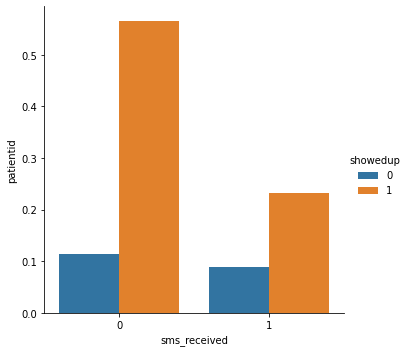

In [16]:
graf1 = df.groupby(['sms_received','showedup']).patientid.count()

sns.catplot(data=pd.DataFrame((graf1/graf1.sum())).reset_index(), kind='bar', hue='showedup', y='patientid', x='sms_received')

That's weird! But it looks like most people that went to their appointments didn't receive an SMS, althought most of those that received an SMS also went to their appointments.

<AxesSubplot:>

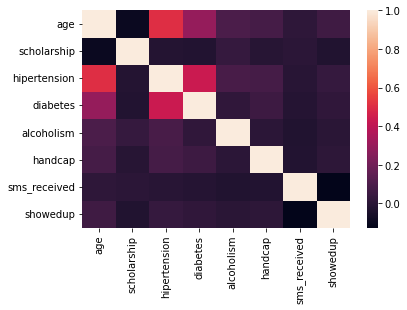

In [17]:
mask = df.copy()
mask.drop(columns=['patientid','appointmentid'], inplace=True)
sns.heatmap(mask.corr())

The correlation matrix confirms our findings above about hipertension, diabetes and age being positively correlated.

# Conclusion

**01. What's the distribution of age and gender?**

Most people has a mean age of 37 and ~60% of the database is Female. Among those that has any kind of health problem their mean age is 58.

**02. How many people has been contemplated by the scholarship?**

Only ~10% of the database has the scholarship

**03. How many people has any kind of health problem or disability?**

There are 26303 people with some kind of disability or health problem, most of them are female and their mean age is 58. The most prevalent problems is hipertension and diabetes.

**04. How many people showed up at their appointments? Did someone make more than one appointment?**

The share of people that showed up on their appointments is ~80% which is composed by 51% of Females and 28% of Males. Looking at the data we have only 37919 people that didn't make more than one appointment, and we have 72607 that made more than one appointment, a total of 110526.